In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from transformers import RobertaTokenizer, T5ForConditionalGeneration

import torch

from tqdm import tqdm

from helper import get_d_j_c_data_loaders, to_device, get_device, plot_data

from pathlib import Path


## Initialize Globals and Model

In [2]:
# GLOBALS
device = get_device()
BEAM_SIZE = 3
MAX_SEQ_LEN = 256
SOURCE_LEN = 256
LEARNING_RATE = 5e-5
EPOCHS = 5
BATCH_SIZE = 64 # change depending on the GPU Colab gives you
VAL_STEP = 20

PRETRAINED_MODEL_PATH = "../../models/java2cs/"
NEW_MODEL_PATH = "../../models/new_trained/java2cs/"
Path(NEW_MODEL_PATH).mkdir(parents=True, exist_ok=True)

dataset_path = "../../datasets/"

torch.cuda.empty_cache()

In [3]:
token = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")
train_dl , valid_dl, test_dl = get_d_j_c_data_loaders(BATCH_SIZE, token
, training_name='train.new.java'
, validation_name='valid.new.java'
, testing_name='test.new.java'
, shuffle_train_val=True)

In [4]:
class JavaToCSModel(torch.nn.Module):
    def __init__(self, tokenizer, model_path, seq_len):
        super(JavaToCSModel, self).__init__()
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.java_to_cs = T5ForConditionalGeneration.from_pretrained(model_path)

    def forward(self, input_ids, attention_mask, labels):
        doc_out = self.java_to_cs(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return doc_out.loss

    def generate_code(self, input_ids):
        gen = self.java_to_cs.generate(input_ids, max_length=self.seq_len)
        return [self.tokenizer.decode(entry, skip_special_tokens=True) for entry in gen]
    
    def save(self, path):
        torch.save(self.state_dict(), path + "JavaToCSModel.pkl")
        self.java_to_cs.save_pretrained(path)

## Train and validation model

In [5]:
@torch.no_grad()
def validate(model, val_load):
    outputs = [model(batch['j_ids'], batch['j_mask'], batch['cs_ids']).detach().cpu() for batch in val_load]
    return np.average(outputs)

In [6]:
def train(clf, opt, dl, val, val_step):
    local_loss = []
    val_loss = []
    for _ in tqdm(range(EPOCHS)):
        for i, data in enumerate(dl):
            mod_out = clf(data['j_ids'], data['j_mask'], data['cs_ids'])
            local_loss.append(mod_out.detach().cpu())
            
            clf.zero_grad()
            mod_out.backward()
            opt.step()

            if i % val_step == 0 and i != 0:
                val_loss.append(validate(clf, val))
        
        print(f"Average Training loss = {np.average(local_loss)}")
        print(f"Average Validation loss = {np.average(val_loss)}")
        
    return local_loss, val_loss

In [7]:
model = to_device(JavaToCSModel(token, PRETRAINED_MODEL_PATH, MAX_SEQ_LEN), device)
rob_optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [8]:
t_loss, v_loss = train(model, rob_optimizer, train_dl, valid_dl, VAL_STEP)

 20%|██        | 1/5 [01:52<07:30, 112.67s/it]

Average Training loss = 0.04514140263199806
Average Validation loss = 0.0527009479701519


 40%|████      | 2/5 [03:35<05:20, 106.74s/it]

Average Training loss = 0.035611849278211594
Average Validation loss = 0.051237545907497406


 60%|██████    | 3/5 [05:17<03:29, 104.65s/it]

Average Training loss = 0.029053090140223503
Average Validation loss = 0.051681388169527054


 80%|████████  | 4/5 [06:59<01:43, 103.71s/it]

Average Training loss = 0.024338729679584503
Average Validation loss = 0.05273972451686859


100%|██████████| 5/5 [08:41<00:00, 104.38s/it]

Average Training loss = 0.020914359018206596
Average Validation loss = 0.05368006229400635


## Save Model

In [9]:
model.save(NEW_MODEL_PATH)

Ls:  805
Ls:  40


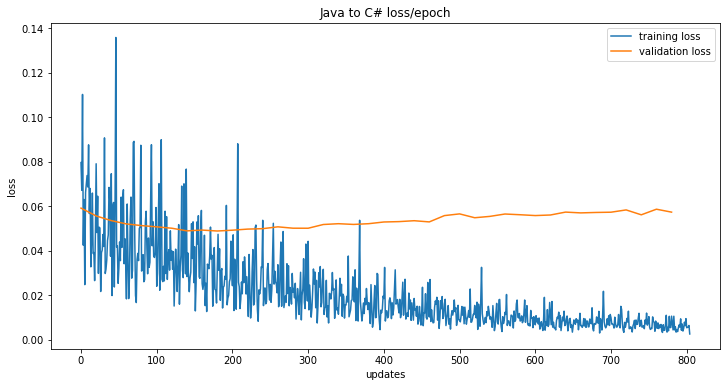

In [10]:
plot_data((t_loss, v_loss ), ('training loss', 'validation loss'), (len(t_loss), len(v_loss) )  , (1, VAL_STEP) , 'updates' , 'loss' , 'Java to C# loss/epoch')

In [11]:
@torch.no_grad()
def sample(clf, dl):
    sent_data = []
    for data in tqdm(dl):
        with torch.no_grad():
            sent_data += clf.generate_code(data['doc_ids'])
        
    return sent_data

In [12]:
doc_data = [sample(model, dl) for dl in (train_dl, valid_dl, test_dl)]

100%|██████████| 16/16 [01:41<00:00,  6.33s/it]


In [20]:

for name, d_data in zip(('train.new.cs', 'valid.new.cs' , 'test.new.cs'), tuple(doc_data)):
    with open(dataset_path + name, 'w') as f:
        for item in d_data:
            f.write("%s\n" % item)

In [50]:
# Save shuffled original files
def save_shuffled(dl, file_name):
    shuffled = []
    for d in dl:
        shuffled += d['cs_unchanged']

    with open(file_name, 'w') as f:
        for item in shuffled:
            f.write("%s\n" % item)

In [51]:
save_shuffled(train_dl, dataset_path + "train.shuffled.cs")
save_shuffled(valid_dl, dataset_path + "valid.shuffled.cs")